<a href="https://colab.research.google.com/github/jbcgames/Laboratorio_1_Procesamiento/blob/main/Proyecto_Sincronizacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Tx a 24khz cuadrada
- portadora a 4mhz y copia a desface de 180°
- selector 1 0° 0 180°
- Aplicar canal
- multiplicar por 4mhz señal en el canal
- comparar

# Generacion Codificacion

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import square
from collections import Counter
import heapq
from itertools import count

class _Node:
    __slots__ = ("freq", "char", "left", "right")
    def __init__(self, freq, char=None, left=None, right=None):
        self.freq = freq
        self.char = char
        self.left = left
        self.right = right

def _build_huffman_tree(message: str) -> _Node:
    """
    Construye el árbol de Huffman para el mensaje.
    Maneja el caso borde de un único símbolo en el mensaje.
    """
    if not message:
        raise ValueError("El mensaje no puede ser vacío.")

    freq = Counter(message)
    pq, tie = [], count() # generador de orden para desempates
    for ch, f in freq.items():
        # (frecuencia, orden, nodo)
        heapq.heappush(pq, (f, next(tie), _Node(f, char=ch)))

    # Caso especial: solo un símbolo -> crea un árbol con un hijo
    if len(pq) == 1:
        f, _, node = heapq.heappop(pq)
        root = _Node(f, left=node, right=None)
        return root

    while len(pq) > 1:
        f1, _, n1 = heapq.heappop(pq)
        f2, _, n2 = heapq.heappop(pq)
        parent = _Node(f1 + f2, left=n1, right=n2)
        heapq.heappush(pq, (parent.freq, next(tie), parent))

    return heapq.heappop(pq)[2]

def _build_codes(root: _Node) -> dict:
    """
    Recorre el árbol y genera el diccionario {caracter: código_en_bits}.
    """
    codes = {}

    def dfs(node, path):
        if node.char is not None:          # hoja
            codes[node.char] = path or "0" # si hay un solo símbolo, asígnale "0"
            return
        if node.left:
            dfs(node.left, path + "0")
        if node.right:
            dfs(node.right, path + "1")

    dfs(root, "")
    return codes

def huffman_encode(message: str):
    """
    Codifica `message` con Huffman.
    Returns:
        bits: str  -> secuencia de '0' y '1'
        codes: dict -> mapa {caracter: código}
    """
    root = _build_huffman_tree(message)
    codes = _build_codes(root)
    bits = "".join(codes[ch] for ch in message)
    return bits, codes

def huffman_decode(bits: str, codes: dict) -> str:
    """
    Decodifica la secuencia de bits usando el diccionario de códigos.
    """
    if not bits and codes:
        return ""  # nada que decodificar

    inv = {code: ch for ch, code in codes.items()}

    out = []
    acc = ""
    for b in bits:
        acc += b
        if acc in inv:
            out.append(inv[acc])
            acc = ""
    if acc:
        raise ValueError("Bits sobrantes: el flujo de bits no coincide con los códigos.")
    return "".join(out)

msg = "Mensaje de prueba"
print(len(msg)*8)
bits, codes = huffman_encode(msg)
print("Bits:", bits)
print("Códigos:", codes)
print(len(bits))
print("Decodificado:", huffman_decode(bits[:len(bits)], codes))
# Agregar 3 bits adificonales en 1 para evitar errores en la decodificacion
bits += '111'



136
Bits: 0110000111100011111001000101010000101011110011010011101111
Códigos: {'e': '00', ' ': '010', 'M': '0110', 'n': '0111', 's': '1000', 'j': '1001', 'd': '1010', 'p': '1011', 'r': '1100', 'u': '1101', 'b': '1110', 'a': '1111'}
58
Decodificado: Mensaje de prueba


# Generacion Portadora

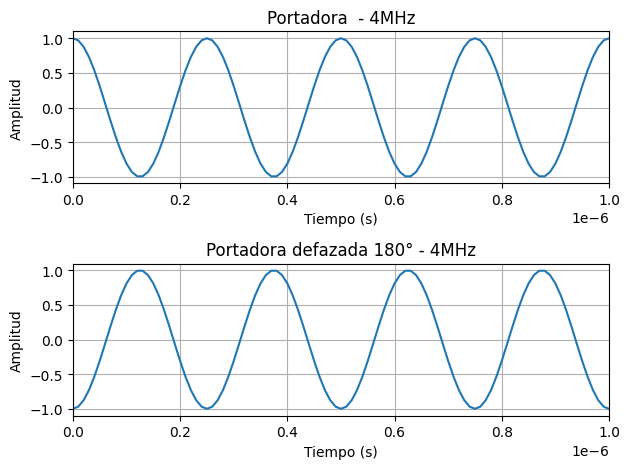

In [ ]:
#generacion de senal de seno de 4mhz
f_seno = 4e6
A_seno = 1
def señal_cosenoidal(f, A=1, desface=0):
    x = A * numpy.cos(2 * numpy.pi * f * t + desface)
    return t, x
# Definir fs para coincidir con la informacion
t_1, X_Portadora1 = señal_cosenoidal(f_seno, A_seno)
t_2, X_Portadora2 = señal_cosenoidal(f_seno, A_seno, desface=numpy.pi) #desface de 180°
ax1 = plt.subplot(2, 1, 1)
ax1.plot(t_1, X_Portadora1)
ax1.set_title('Portadora  - 4MHz')
ax1.set_xlabel('Tiempo (s)')
ax1.set_ylabel('Amplitud')
ax1.grid()
plt.xlim(0, 0.000001)  # Ajustar el límite del eje x para ver mejor la señal
ax2 = plt.subplot(2, 1, 2)
ax2.plot(t_2, X_Portadora2)
ax2.set_title('Portadora defazada 180° - 4MHz')
ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel('Amplitud')
ax2.grid()
plt.xlim(0, 0.000001)  # Ajustar el límite del eje x para ver mejor la señal
plt.tight_layout()
plt.show()

# Selector

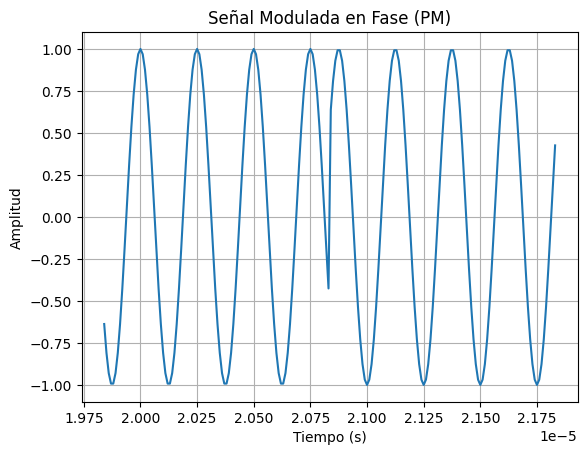

In [ ]:
# si 1 entonces portadora 1
# si 0 entonces portadora 2
# Crear switche

def switche(t, x_codificacion, x_portadora1, x_portadora2,):
    x_fm = numpy.zeros_like(t)
    primer=0
    for i in range(len(t)):
        if x_codificacion[i] > 0.5:  # umbral para decidir entre 0 y 1
            x_fm[i] = x_portadora1[i]

        else:
            x_fm[i] = x_portadora2[i]
            if primer==0:
                primer=i
    return x_fm, primer
x_fm, primer = switche(t_Codificacion, x_Codificacion, X_Portadora1, X_Portadora2)
# Graficar la señal modulada
plt.figure()
plt.plot(t_Codificacion[primer-100:primer+100], x_fm[primer-100:primer+100])
plt.title('Señal Modulada en Fase (PM)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

# Crear Canal

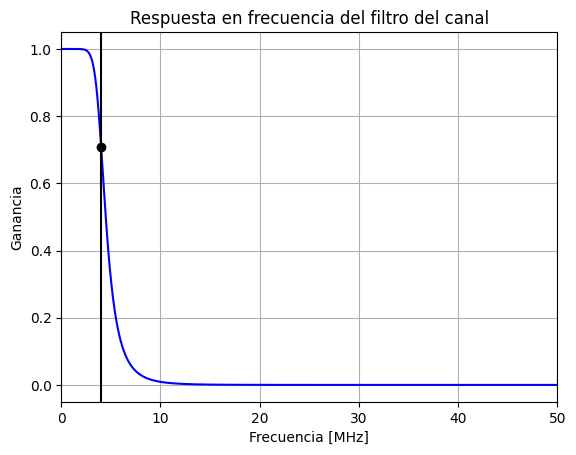

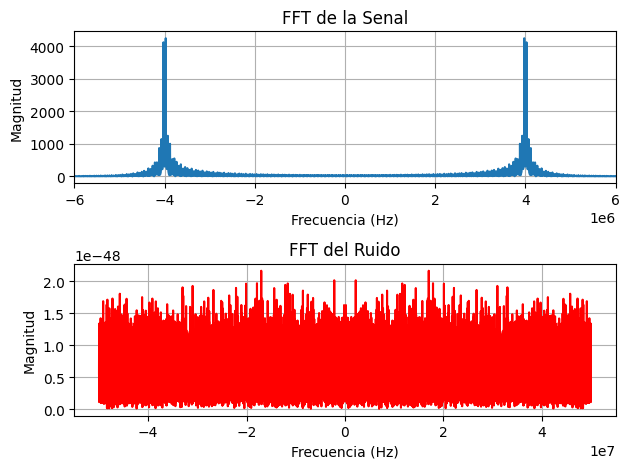

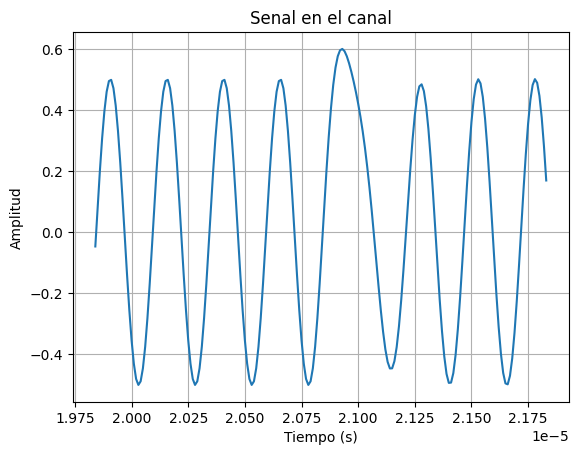

In [ ]:
# Se debe simular un canal que contenga un LPF, atenuacion y ruido gaussiano
### Creacion del canal
from scipy.signal import lfilter
def filtro_LTF(f_c, fs, orden=5):
    # f_c: frecuencia de corte
    # fs: frecuencia de muestreo
    # orden: orden del filtro
    from scipy.signal import butter, lfilter
    nyquist = 0.5 * fs
    normal_cutoff = f_c / nyquist
    b, a = butter(orden, normal_cutoff, btype='low', analog=False)
    return b, a
# Aplicacion de filtro LTF a senal modulada
def aplicar_filtro(x, b, a):
    y = lfilter(b, a, x)
    return y
def crear_canal(x, fs, fc, atenuacion_db, snr_db=20):
    # Filtro LTF
    b, a = filtro_LTF(fc, fs)
    # Simular respuesta natural del filtro del canal
    w, h = freqz(b, a, worN=100*32000)
    plt.figure()
    plt.plot((0.16*fs*numpy.pi*w/numpy.pi)/1e6, numpy.abs(h), 'b')
    plt.plot(fc/1e6, 0.5*numpy.sqrt(2), 'ko')
    plt.axvline(fc/1e6, color='k')
    plt.xlim(0, 0.5*fs/1e6)
    plt.title("Respuesta en frecuencia del filtro del canal")
    plt.xlabel('Frecuencia [MHz]')
    plt.ylabel('Ganancia')
    plt.grid()
    plt.show()

    x_filtrada = aplicar_filtro(x, b, a)
    # Atenuacion
    x_ruidos = agregar_ruido_gaussiano(x_filtrada, snr_db)  # SNR de 20 dB
    atenuacion = 10 ** (atenuacion_db / 20)
    X_atenuada = x_ruidos * atenuacion

    return X_atenuada
# Adicion de ruido gaussiano
def agregar_ruido_gaussiano(x, snr_db):
    # Calcular potencia de la señal
    potencia_senal = numpy.mean(x**2)
    # Calcular potencia del ruido
    snr = 10 ** (snr_db / 10)
    potencia_ruido = potencia_senal / snr
    # Generar ruido gaussiano hasta 800 Mhz
    ruido = numpy.random.normal(0, numpy.sqrt(potencia_ruido), len(x))
    # Señal con ruido
    x_ruidosa = x + ruido
    #Graficacion FFT del Ruido
    f, X = aplicar_fft(x_ruidosa, fs)
    f_ruido, R = aplicar_fft(ruido, fs)
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(f, numpy.abs(X), label='Senal')
    plt.title('FFT de la Senal')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Magnitud')
    #plt.ylim(0, 500)
    plt.xlim(-6e6, 6e6)
    plt.grid()
    plt.subplot(2,1,2)
    plt.plot(f_ruido, numpy.abs(R), label='Ruido', color='red')
    plt.title('FFT del Ruido')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Magnitud')
    plt.grid()
    plt.tight_layout()
    plt.show()
    return x_ruidosa
# Prueba de canal
fc = 4e6
#aplicar el canal a la señal con codificacion unipolar
x_canal = crear_canal(x_fm, fs, fc, atenuacion_db= -3 , snr_db=1000)
t_canal = t
plt.figure()
longitud=int(len(t)/50)
tempo=625
plt.plot(t_canal[primer-100:primer+100],x_canal[primer-100:primer+100], label='Senal en el canal')
plt.title('Senal en el canal')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()


# Detectar fase de la señal

Fase estimada (radianes): 2.4525878032933726


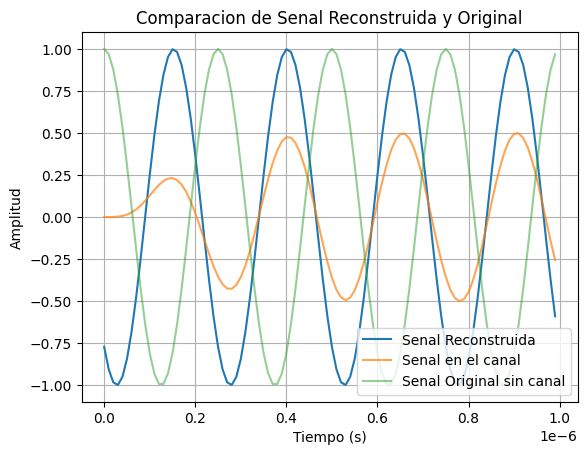

In [ ]:
def estimar_fase(signal):
    # Calcular la transformada de Fourier de la señal
    fft_signal = numpy.fft.fft(signal)
    # Obtener el índice de la frecuencia fundamental (mayor magnitud)
    fundamental_index = numpy.argmax(numpy.abs(fft_signal))
    # Calcular la fase en radianes
    phase = numpy.angle(fft_signal[fundamental_index])
    return phase
# Detectar fase de la señal de los primeros 4 ciclos
fase_estimada = estimar_fase(x_canal[0:100])
print("Fase estimada (radianes):", fase_estimada)
# Generar señal cosenoidal con fase estimada
t_reconstruida, x_reconstruida = señal_cosenoidal(f_seno, A_seno, desface=fase_estimada)
# Comparar con la señal original
plt.figure()
plt.plot(t_reconstruida[0:100], x_reconstruida[0:100], label='Senal Reconstruida')
plt.plot(t_1[0:100], x_canal[0:100], label='Senal en el canal', alpha=0.7)
plt.plot(t_1[0:100], X_Portadora1[0:100], label='Senal Original sin canal', alpha=0.5)
plt.title('Comparacion de Senal Reconstruida y Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid()
plt.show()

# Multiplicacion por 4MHZ

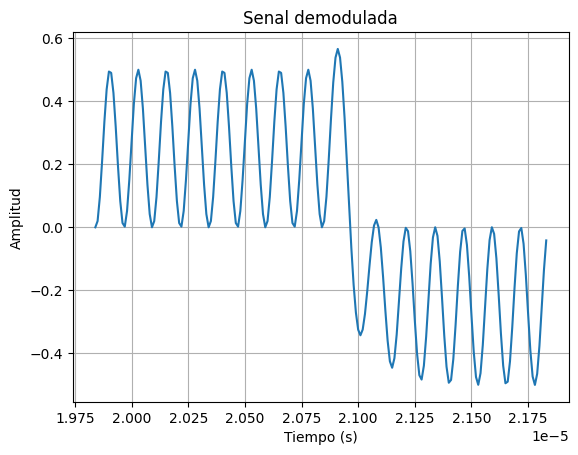

In [ ]:
#Normalizacion de la señal recibida
X_canal = x_canal / numpy.max(numpy.abs(x_canal))

X_demodulada = x_canal * x_reconstruida
# Graficar la señal demodulada
plt.figure()
plt.plot(t_canal[primer-100:primer+100],X_demodulada[primer-100:primer+100], label='Senal demodulada')
plt.title('Senal demodulada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

# Filtrar Pasa baja

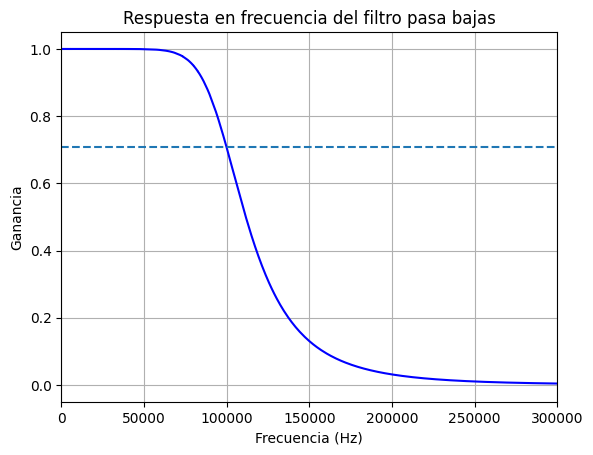

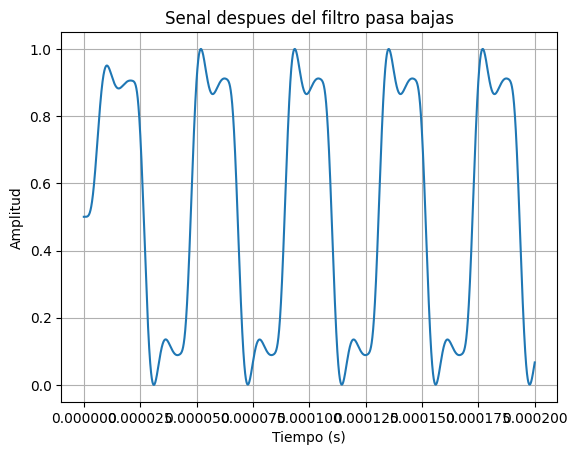

In [ ]:
from scipy.signal import lfilter
def filtro_LTF(f_c, fs, orden=5):
    # f_c: frecuencia de corte
    # fs: frecuencia de muestreo
    # orden: orden del filtro
    from scipy.signal import butter, lfilter
    nyquist = 0.5 * fs
    normal_cutoff = f_c / nyquist
    b, a = butter(orden, normal_cutoff, btype='low', analog=False)
    return b, a
# Aplicacion de filtro LTF a senal modulada
def aplicar_filtro(x, b, a):
    y = lfilter(b, a, x)
    return y
# Respuesta natural del filtro
b, a = filtro_LTF(100e3, fs, orden=5)
w, h = freqz(b, a, worN=100*32000)
plt.figure()
plt.plot(0.5*fs*w/numpy.pi, numpy.abs(h), 'b')
plt.plot([0, 0.5*fs], [numpy.sqrt(0.5), numpy.sqrt(0.5)], '--')
plt.title('Respuesta en frecuencia del filtro pasa bajas')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Ganancia')
plt.xlim(0, 30e4)
plt.grid()
plt.show()
# Aplicacion del filtro pasa bajas a la senal despues del filtro pasa banda
x_filtrada_pj1 = lfilter(b, a, X_demodulada)

#Normalizar
x_filtrada_normalizada1 = (x_filtrada_pj1 - numpy.min(x_filtrada_pj1)) / (numpy.max(x_filtrada_pj1) - numpy.min(x_filtrada_pj1))
t_filtrada_pj = t
plt.figure()
plt.plot(t_filtrada_pj, x_filtrada_normalizada1, label='Senal filtrada pasa bajas')
plt.title('Senal despues del filtro pasa bajas')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()
# espectro de la senal antes y despues del filtro pasa bajas



# Comparacion

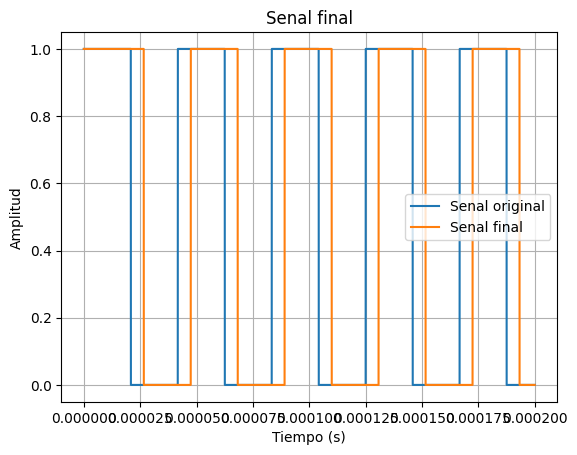

In [ ]:
x_final = numpy.zeros_like(x_filtrada_normalizada1)
for i in range(len(x_filtrada_normalizada1)):
    if x_filtrada_normalizada1[i] > 0.5:
        x_final[i] = 1
    else:
        x_final[i] = 0
# Graficar la señal demodulada
plt.figure()
plt.plot(t_Codificacion, x2, label='Senal original')
plt.plot(t_canal,x_final, label='Senal final')
plt.title('Senal final')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.legend()
plt.show()
